<a href="https://colab.research.google.com/github/ismailnajah/Gender_Prediction_from_handwritting_using_CNN_model/blob/main/CNN_Model_gender_prediction_from_handwritting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepLearning aproche for gender prediction from handwriting images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
from tqdm import tqdm
from sklearn.feature_extraction import image
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_curve, auc
from keras.models import model_from_json

## Utility functions

In [2]:
def crop_image(img,tol=240):
    mask = img<tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def show_img(img,title=''):
  plt.figure(figsize=[8,4])
  plt.title(title)
  plt.imshow(img, cmap='gray')
  plt.show()

def show_grid_imgs(data,n):
  plt.figure(figsize=(6,6))
  for i in range(0,n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(data[random.randint(0,len(data))],cmap='gray')
  plt.show()

def resize(img,h):
  fixed_height = h
  height_percent = (fixed_height / float(img.shape[0]))
  width_size = int((float(img.shape[1]) * float(height_percent)))
  img = cv2.resize(img,(width_size, fixed_height))
  return img

def get_image(id,folder):
  path = os.path.join(DATADIR, f"{folder}/{id}.jpg")
  img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  return img_array


def sklearn_patches(img,window_size,nb_patches):
  blur = cv2.GaussianBlur(img,(5,5),0)
  ret3,tg = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  src_img = crop_image(tg)
  if src_img.shape[0] <= window_size[0]:
    src_img = resize(src_img,10+window_size[0])
  patches = image.extract_patches_2d(
      src_img, 
      patch_size=window_size,
      max_patches=nb_patches,
      random_state=np.random.RandomState(round(time.time()))
  )
  return patches

def load_data(csv_file,category):
  X=[]
  y=[]
  for entry in tqdm(csv_file):
    img_array = cv2.resize(get_image(f'image_{entry[0]}',category),IMG_SIZE)
    X.append(img_array)
    y.append(entry[1])
  X = np.array(X).reshape( -1, IMG_SIZE[0], IMG_SIZE[1], 1)
  X = X/255.0
  y = np.array(y)
  return X,y

## Creating Training Dataset

In [3]:
DATADIR = '/content/drive/MyDrive/Dataset' #path to google drive dataset
train_csv_path = '/content/drive/MyDrive/Dataset/Train/GT_2B_Training.csv'
val_csv_path = '/content/drive/MyDrive/Dataset/Validation/GT_2B_Validation.csv'
out_dir = '/content/Datagen'

Cleaning original image example

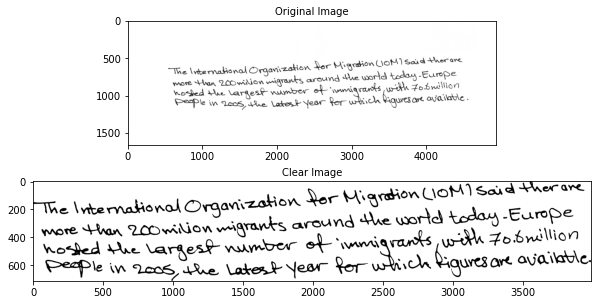

In [ ]:
original = get_image('Image_75','Train')
blur = cv2.GaussianBlur(original,(5,5),0)
ret3,tg = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
clean_image = crop_image(tg)
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Original Image',fontsize=10)
plt.imshow(original,cmap='gray')
plt.subplot(2,1,2)
plt.title('Clear Image',fontsize=10)
plt.imshow(clean_image,cmap='gray')

plt.show()

### ImageDatagenerator

This section illustrates the data preprocessing steps, first we load each image that contatins the full paragraph and we slice it into multiple pieces (using sklearn_patches function defined above) that contains chuncks of handwriten text.  

In [11]:
IMG_SIZE = (200,200)
window_size = (800,800)
npatches = 100

def generate_datagen(csv_file_path,category):
  id=1
  csv_file = pd.read_csv(csv_file_path,sep=';').to_numpy()
  for entry in tqdm(csv_file):
    #read the image
    img = get_image(f'Image_{entry[0]}',category)
    label = entry[1]
    patches = sklearn_patches(img, window_size, npatches)
    for p in patches:
      #p = cv2.bitwise_not(p)
      gender = 'Male'
      if label == 0:
        gender= 'Female'
      path = f'{out_dir}/{category}/{gender}/image_{id}.jpg'
      
      #resize image
      p = cv2.resize(p,IMG_SIZE)
      cv2.imwrite(path, p)
      id += 1

creating generated data folders

In [ ]:
!rm -rf /content/Datagen
!mkdir -p /content/Datagen/Train/Male
!mkdir -p /content/Datagen/Train/Female
!mkdir -p /content/Datagen/Validation/Male
!mkdir -p /content/Datagen/Validation/Female

In [ ]:
generate_datagen(train_csv_path,'Train')
generate_datagen(val_csv_path,'Validation')

100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


In [ ]:
batch_size = 16
datagen = ImageDataGenerator(
        rotation_range=15,
        rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.5,
        fill_mode='wrap')

train_generator = datagen.flow_from_directory(
        '/content/Datagen/Train',  # this is the target directory
        target_size=(200, 200),  # all images will be resized to 200x200
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='binary')


validation_generator = datagen.flow_from_directory(
        '/content/Datagen/Validation',  # this is the target directory
        target_size=(200, 200),  # all images will be resized to 200x200
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='binary')

Found 30000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


### Data Visualisation

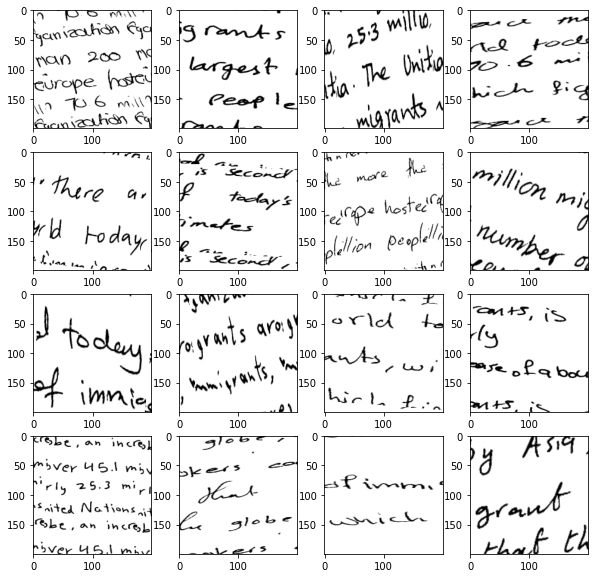

In [ ]:
plt.figure(figsize=(10,10))
n = 4
for i in range(0,n*n):
  batch = train_generator.next()
  image_ = batch[0][0].astype('float32')
  image_ = np.array(image_).reshape(IMG_SIZE[0], IMG_SIZE[1])
  plt.subplot(n,n,i+1)
  plt.imshow(image_,cmap='gray')
plt.show()

## Building and Training the CNN Model


### CNN model

In [ ]:
input_shape = (IMG_SIZE[0],IMG_SIZE[1],1)

def create_model():
  model = tf.keras.models.Sequential([
  #first layer
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
  tf.keras.layers.MaxPooling2D(2, 2),
  #second convolution
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  #third layer
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.25),
  #fourth layer
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.25),
  #fifth layer
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  
  # Flatten the results to feed into a DNN
  tf.keras.layers.Flatten(),
  # 512 neuron hidden layer
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  
  # Only 1 output neuron.(1 male, 0 female)
  tf.keras.layers.Dense(1, activation='sigmoid')])

  return model


#,kernel_regularizer=regularizers.l2(0.0001)

In [ ]:
model = create_model()
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

### Training the model

In [ ]:
t_history = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks = [EarlyStopping(monitor='val_accuracy', patience=10)]
        )

Epoch 1/30
1875/1875 [==============================] - 149s 73ms/step - loss: 0.6834 - accuracy: 0.5484 - val_loss: 0.6908 - val_accuracy: 0.5565
Epoch 2/30
1875/1875 [==============================] - 133s 71ms/step - loss: 0.6403 - accuracy: 0.6338 - val_loss: 0.6641 - val_accuracy: 0.5591
Epoch 3/30
1875/1875 [==============================] - 133s 71ms/step - loss: 0.6090 - accuracy: 0.6741 - val_loss: 0.6842 - val_accuracy: 0.5671
Epoch 4/30
1875/1875 [==============================] - 133s 71ms/step - loss: 0.5917 - accuracy: 0.6910 - val_loss: 0.6570 - val_accuracy: 0.6418
Epoch 5/30
1875/1875 [==============================] - 133s 71ms/step - loss: 0.5854 - accuracy: 0.6998 - val_loss: 0.6765 - val_accuracy: 0.6160
Epoch 6/30
1875/1875 [==============================] - 133s 71ms/step - loss: 0.5846 - accuracy: 0.7013 - val_loss: 0.7227 - val_accuracy: 0.6184
Epoch 7/30
1875/1875 [==============================] - 133s 71ms/step - loss: 0.5820 - accuracy: 0.7048 - val_loss: 0

#### Training Results


Text(0.5, 1.0, 'Loss Curves')

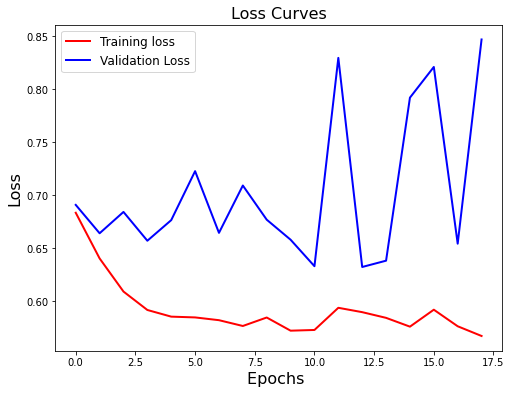

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(t_history.history['loss'],'r',linewidth=2.0)
plt.plot(t_history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

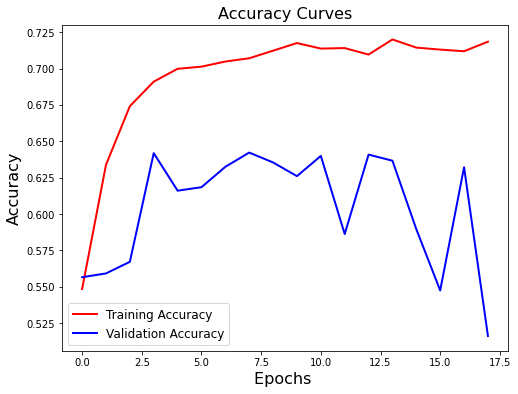

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(t_history.history['accuracy'],'r',linewidth=2.0)
plt.plot(t_history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

load validation data

In [ ]:
validation = datagen.flow_from_directory(
            '/content/Datagen/Validation',  # this is the target directory
            target_size=IMG_SIZE,  # all images will be resized to 200x200
            batch_size=10000,
            color_mode="grayscale",
            class_mode='binary')


Found 10000 images belonging to 2 classes.


In [ ]:
X_val , y_val = validation.next()

In [ ]:
print(len(X_val))

10000


In [ ]:
preds = model.predict(X_val,verbose=1)

313/313 [==============================] - 3s 8ms/step


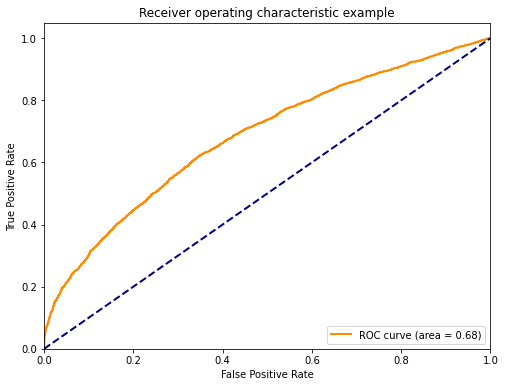

In [ ]:
fpr, tpr, _ = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[8,6])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Save and Load models

In [4]:
path = '/content/drive/MyDrive/Models'
version = 4.0

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(f"{path}/model_{version}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{path}/model_{version}.h5")
print("Saved model to disk")

Saved model to disk


## Model evaluation

### Load test data

In [ ]:
!unrar x "/content/drive/MyDrive/Kaggle.rar" "/content"

In [ ]:
out_dir = '/content/Test_dataset'

def generate_Test_dataset(csv_file_path,category):
  id=1
  out_csv = {'image_ID':[],'Gender':[]}
  csv_file = pd.read_csv(csv_file_path,sep=',').to_numpy()
  for entry in tqdm(csv_file):
    path = os.path.join(DATADIR, f"{category}/{str(entry[0]).zfill(4)}_3.jpg")
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label = entry[1]
    patches = sklearn_patches(img, window_size,npatches)

    for p in patches:
      path = f'{out_dir}/{category}/image_{id}.jpg'
      cv2.imwrite(path, p)
      out_csv['image_ID'].append(id)
      out_csv['Gender'].append(label)
      id += 1

  csv_path = f'{out_dir}/{category}_image_IDs.csv'
  out = pd.DataFrame(out_csv)
  out.to_csv(csv_path,sep=';',index=False)
  print(f'{category} Dataset Generated Successfully')

In [ ]:
!rm -rf /content/Test_dataset
!mkdir -p /content/Test_dataset/Test

In [ ]:
DATADIR = '/content/Kaggle'
test_csv_path = '/content/Kaggle/Test.csv'
generate_Test_dataset(test_csv_path,'Test')

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

Test Dataset Generated Successfully


In [ ]:
DATADIR = '/content/Test_dataset'
test_csv_path = '/content/Test_dataset/Test_image_IDs.csv'
test_csv = pd.read_csv(test_csv_path,sep=';').to_numpy()
np.random.shuffle(test_csv)

In [ ]:
X_test,y_test = load_data(test_csv,'Test')

100%|██████████| 10000/10000 [01:00<00:00, 165.48it/s]


### Load Model

In [5]:
# load json and create model
json_file = open(f"{path}/model_{version}.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(f"{path}/model_{version}.h5")
print(f"Loaded model version {version} from disk")

Loaded model version 4.0 from disk


In [6]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [7]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [ ]:
preds = loaded_model.predict(X_test,verbose=1)

313/313 [==============================] - 3s 9ms/step


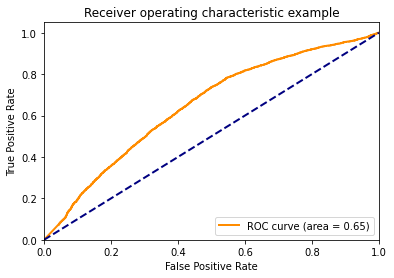

In [ ]:
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Prediction Scenario

In [8]:
window_size = (800,800)
def predict_gender(model, img):
  patches = sklearn_patches(img, window_size,100)
  show_img(patches[0])
  results = []
  for p in patches:
    m = cv2.resize(p,IMG_SIZE).reshape(1,IMG_SIZE[0],IMG_SIZE[1],1)
    m = m/255
    prediction = loaded_model.predict(m)
    results.append(loaded_model.predict(m)[0][0])
  ratio = np.sum(results) / len(results)
  if ratio > 0.5:
    print(f'pridected gender : Male | accuracy {ratio:.3}')
  else:
    print(f'pridected gender : Female | accuracy {(1-ratio):.3}')

Testing model on a random female text 

<Figure size 720x720 with 0 Axes>

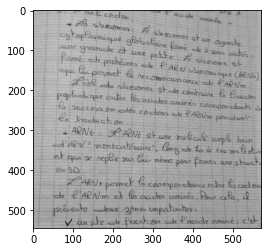

In [9]:
path = "/content/Female.jpg"
img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10,10))
show_img(img_array)

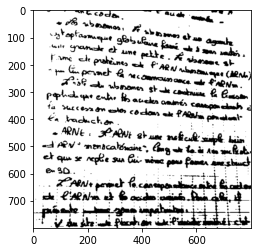

pridected gender : Female | accuracy 0.955


In [12]:
predict_gender(loaded_model, img_array)

Testing the model on a random male French text 

<Figure size 720x720 with 0 Axes>

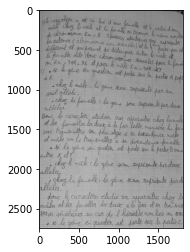

In [13]:
path = "/content/Male.jpg"
img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10,10))
show_img(img_array)

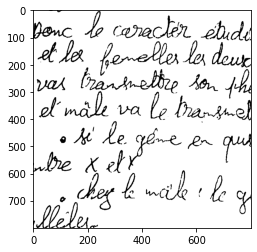

pridected gender : Male | accuracy 0.781


In [14]:
predict_gender(loaded_model, img_array)